# MCMC Sampling

The  `CmdStanModel` class method  `sample` invokes Stan's adaptive HMC-NUTS
sampler which uses the Hamiltonian Monte Carlo (HMC) algorithm
and its adaptive variant the no-U-turn sampler (NUTS) to produce a set of
draws from the posterior distribution of the model parameters conditioned on the data.
It returns a `CmdStanMCMC` object
which provides properties to retrieve information about the sample, as well as methods
to run CmdStan's summary and diagnostics tools.

In order to evaluate the fit of the model to the data, it is necessary to run
several Monte Carlo chains and compare the set of draws returned by each.
By default, the `sample` command runs 4 sampler chains, i.e.,
CmdStanPy invokes CmdStan 4 times.
CmdStanPy uses Python's `subprocess` and `multiprocessing` libraries
to run these chains in separate processes.
This processing can be done in parallel, up to the number of
processor cores available.

## Prerequisites


CmdStanPy displays progress bars during sampling via use of package [tqdm](https://github.com/tqdm/tqdm).
In order for these to display properly, you must have the 
[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html) package installed,
and depending on your version of Jupyter or JupyterLab, you must enable it via command:

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


For more information, see the the
[installation instructions](https://ipywidgets.readthedocs.io/en/latest/user_install.html#), 
also [this tqdm GitHub issue](https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637).


    

## Fitting a model to data

In this example we use the CmdStan example model
[bernoulli.stan](https://github.com/stan-dev/cmdstanpy/blob/master/test/data/bernoulli.stan)
and data file
[bernoulli.data.json](https://github.com/stan-dev/cmdstanpy/blob/master/test/data/bernoulli.data.json>).

We instantiate a `CmdStanModel` from the Stan program file

In [2]:
import os
from cmdstanpy import CmdStanModel, cmdstan_path
    
bernoulli_dir = os.path.join(cmdstan_path(), 'examples', 'bernoulli')
stan_file = os.path.join(bernoulli_dir, 'bernoulli.stan')
data_file = os.path.join(bernoulli_dir, 'bernoulli.data.json')

# instantiate, compile bernoulli model
model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:found newer exe file, not recompiling


By default, the model is compiled during instantiation.  The compiled executable is created in the same directory as the program file.  If the directory already contains an executable file with a newer timestamp, the model is not recompiled.

We run the sampler on the data using all default settings:  4 chains, each of which runs 1000 warmup and sampling iterations.

In [3]:
# run CmdStan's sample method, returns object `CmdStanMCMC`
fit = model.sample(data=data_file)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


The `sample` method returns a `CmdStanMCMC` object, which contains:
- metadata
- draws
- HMC tuning parameters `metric`, `step_size`

In [4]:
print('sampler diagnostic variables:\n{}'.format(fit.metadata.method_vars_cols.keys()))
print('stan model variables:\n{}'.format(fit.metadata.stan_vars_cols.keys()))

sampler diagnostic variables:
dict_keys(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'])
stan model variables:
dict_keys(['theta'])


In [5]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.255110,0.015796,0.699083,-8.684700,-6.982850,-6.749900,1958.72,8943.95,1.000680
theta,0.251272,0.002883,0.119460,0.083697,0.237794,0.469379,1716.92,7839.82,0.999185


The sampling data from the fit can be accessed either as a `numpy` array or a pandas `DataFrame`:

In [6]:
print(fit.draws().shape)
fit.draws_pd().head()

(1000, 4, 8)


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta
0,-6.89321,0.960690,1.10269,1.0,3.0,0.0,6.89615,0.186989
1,-6.96713,0.874857,1.10269,2.0,3.0,0.0,7.42810,0.338126
2,-7.05870,0.978921,1.10269,2.0,3.0,0.0,7.15992,0.355949
3,-7.47747,0.805845,1.10269,1.0,1.0,0.0,7.62988,0.416678
4,-6.86860,0.911387,1.10269,2.0,3.0,0.0,7.73696,0.192206


Additionally, if `xarray` is installed, this data can be accessed another way:

In [7]:
fit.draws_xr()

<xarray.Dataset>
Dimensions:  (draw: 1000, chain: 4)
Coordinates:
  * chain    (chain) int64 1 2 3 4
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (chain, draw) float64 0.187 0.3381 0.3559 ... 0.4468 0.5279 0.07333
Attributes:
    stan_version:        2.29.2
    model:               bernoulli_model
    num_draws_sampling:  1000

The ``fit`` object records the command, the return code,
and the paths to the sampler output csv and console files.
The string representation of this object displays the CmdStan commands and
the location of the output files.

Output filenames are composed of the model name, a timestamp
in the form YYYYMMDDhhmm and the chain id, plus the corresponding
filetype suffix, either '.csv' for the CmdStan output or '.txt' for
the console messages, e.g. `bernoulli-201912081451-1.csv`. Output files
written to the temporary directory contain an additional 8-character
random string, e.g. `bernoulli-201912081451-1-5nm6as7u.csv`.

In [8]:
fit

CmdStanMCMC: model=bernoulli chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/bernoulli-20220616151107_1.csv
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/bernoulli-20220616151107_2.csv
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/bernoulli-20220616151107_3.csv
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/bernoulli-20220616151107_4.csv
 output_files:
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/bernoulli-20220616151107_0-stdout.txt
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/bernoulli-20220616151107_1-stdout.txt
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/bernoulli-20220616151107_2-stdout.txt
	/var/folders/l4/n2cw06zx4cl_yc5xnq71rym00000gn/T/tmpuow8u6m1/bernoullil0oepyx_/b

The sampler output files are written to a temporary directory which
is deleted upon session exit unless the ``output_dir`` argument is specified.
The ``save_csvfiles`` function moves the CmdStan CSV output files
to a specified directory without having to re-run the sampler.
The console output files are not saved. These files are treated as ephemeral; if the sample is valid, all relevant information is recorded in the CSV files.

### Sampler Progress

Your model make take a long time to fit.  The `sample` method provides two arguments:
    
- visual progress bar:  `show_progress=True`
- stream CmdStan ouput to the console - `show_console=True`
    
To illustrate how progress bars work, we will run the bernoulli model. Since the progress bars are only visible while the sampler is running and the bernoulli model takes no time at all to fit, we run this model for 200K iterations, in order to see the progress bars in action.

In [9]:
fit = model.sample(data=data_file, iter_warmup=100000, iter_sampling=100000, show_progress=True)


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


The Stan language `print` statement can be use to monitor the Stan program state.
In order to see this information as the sampler is running, use the `show_console=True` argument.
This will stream all CmdStan messages to the terminal while the sampler is running.


In [10]:
fit = model.sample(data=data_file, chains=2, parallel_chains=1, show_console=True)



INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [2] done processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /Users/meenaljhajharia/cmdstan/examples/bernoulli/bernoulli.data.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain

## Running a data-generating model

In this example we use the CmdStan example model
[data_filegen.stan](https://github.com/stan-dev/cmdstanpy/blob/master/docs/notebooks/data_filegen.stan)
to generate a simulated dataset given fixed data values.

In [11]:
model_datagen = CmdStanModel(stan_file='bernoulli_datagen.stan')
datagen_data = {'N':300, 'theta':0.3}
fit_sim = model_datagen.sample(data=datagen_data, fixed_param=True)
fit_sim.summary()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.000,NaN,0.00000,0,0,0,NaN,NaN,NaN
theta_rep,90.136,0.254026,7.86851,78,90,104,959.46,39977.5,1.00547


Compute, plot histogram of total successes for `N` Bernoulli trials with chance of success `theta`:

<AxesSubplot:ylabel='Frequency'>

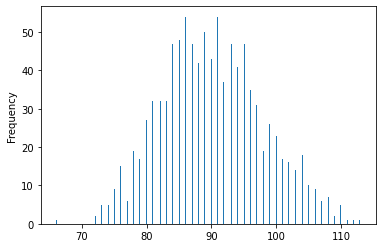

In [12]:
fit_sim.draws_pd()['theta_rep'].plot.hist(bins=datagen_data['N'])